In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from zipfile import ZipFile
from functools import reduce

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
!pip install -q gdown httpimport
!gdown 'https://github.com/wenjie-hoo/baltic_ml/raw/main/2022.11.07-merged-single-observation.zip'

Downloading...
From: https://github.com/wenjie-hoo/baltic_ml/raw/main/2022.11.07-merged-single-observation.zip
To: /home/robert/Desktop/baltic_ml/2022.11.07-merged-single-observation.zip
100%|████████████████████████████████████████| 329k/329k [00:00<00:00, 2.45MB/s]


In [3]:
zip_file = ZipFile('./2022.11.07-merged-single-observation.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv') and not text_file.filename[37:].startswith('.')}

df_list=[]
for df in dfs.values():
       df['DATE'] = pd.to_datetime(df['DATE'],dayfirst = True)
       df_list.append(df)

df = reduce(lambda left,right: pd.merge(left.drop_duplicates(subset=['DATE','DEPTH']),right.drop_duplicates(subset=['DATE','DEPTH']),on=['DATE','DEPTH'],how='outer'), df_list)
# df.to_csv('xxxxx.csv')
df.head

<bound method NDFrame.head of            DATE  DEPTH  CHLORA  CTDSAL  CTDTMP  NH4  NO2  NO3    OXY  PH  \
0    1960-03-31    500     2.9    17.9     2.2  NaN  NaN  NaN  515.6 NaN   
1    1960-03-31   2600    26.5    20.0     1.5  NaN  NaN  NaN  396.9 NaN   
2    1960-03-31    100     2.8    17.8     2.2  NaN  NaN  NaN  421.9 NaN   
3    1960-03-31   2000     7.9    18.7     1.9  NaN  NaN  NaN  478.1 NaN   
4    1960-03-31   1500     6.6    18.5     2.1  NaN  NaN  NaN  471.9 NaN   
...         ...    ...     ...     ...     ...  ...  ...  ...    ...  ..   
4763 1960-03-02   1500     NaN    20.5     1.4  NaN  NaN  NaN  375.0 NaN   
4764 1960-03-02   2000     NaN    20.5     1.3  NaN  NaN  NaN  412.5 NaN   
4765 1960-03-02    100     NaN    20.4     1.6  NaN  NaN  NaN  356.3 NaN   
4766 1960-03-02   1000     NaN    20.4     1.5  NaN  NaN  NaN  462.5 NaN   
4767 1960-03-02    500     NaN    20.4     1.6  NaN  NaN  NaN  343.8 NaN   

       PO4  SECCHI  SIO2  TN    TP  
0     0.03     NaN  

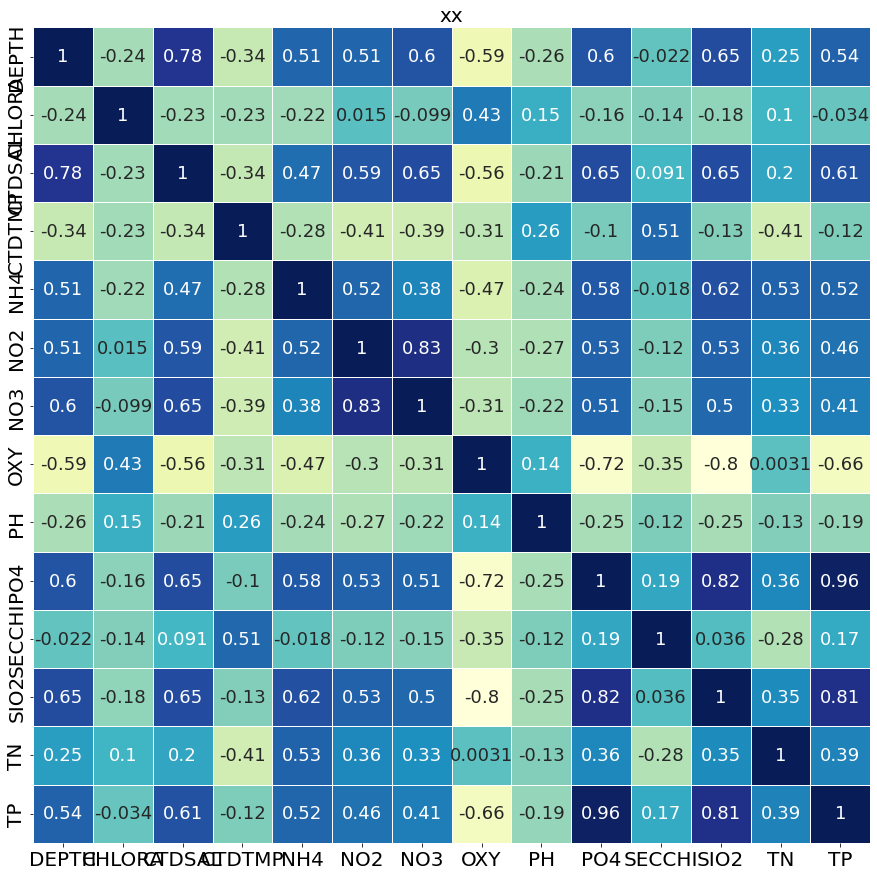

In [7]:
df.dropna(inplace=True)

fig = plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':18})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('xx',fontsize=20)
plt.show()

In [8]:
df['TP'] = df['TP']
X = df.drop(['DATE'],axis=1)
y = df['PO4']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
scaler = StandardScaler(with_mean = True, with_std = True)
scaler.fit(x_train)
norm_X = scaler.transform(x_train)
norm_X_test = scaler.transform(x_test)

In [10]:
# linear regression
lg = LinearRegression()
lg.fit(norm_X, y_train)
y_pred = lg.predict(norm_X_test)
print(mean_squared_error(y_test,y_pred))

1.1539919448463116e-31


In [11]:
# neural netword
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(2,2), solver='sgd', max_iter=3000)
mlp.fit(norm_X,y_train)
y_pred = mlp.predict(norm_X_test)
print(mean_squared_error(y_test, y_pred))

0.4100250841883233


In [12]:
# random forest 
rfr = RandomForestRegressor(random_state=0)
rfr.fit(norm_X, y_train)
y_pred = rfr.predict(norm_X_test)
print(mean_squared_error(y_test, y_pred))

0.015457192000000087


1 PO4 0.731574191991062
2 SIO2 0.10239859198097583
3 TP 0.08179635386921091
4 OXY 0.048119813018364314
5 SECCHI 0.010917719898014164
6 PH 0.007217316302229131
7 CHLORA 0.006585494335507413
8 CTDTMP 0.0032360514442429647
9 NO2 0.002036300148471233
10 CTDSAL 0.0019670389289775745
11 NO3 0.0017603145485383946
12 NH4 0.0014297544262031568
13 TN 0.0007781838176138103


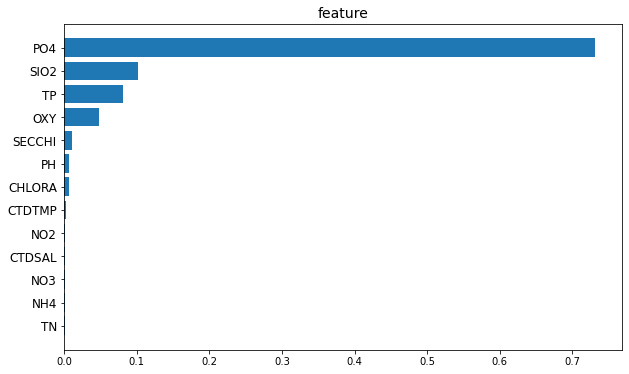

In [13]:
feat_lebels = x_train.columns[0:]
importances  = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
index_list = []
value_list = []
for i,j in zip(range(x_train.shape[1]-1),indices):
    index_list.append(feat_lebels[j])
    value_list.append(importances[j])
    print(i+1, feat_lebels[j], importances[j])

plt.figure(figsize=(10,6))
plt.barh(index_list[::-1],value_list[::-1])
plt.yticks(fontsize = 12)
plt.title('feature',fontsize = 14)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':[150,200,300],
    'min_samples_split':[2,3,5],
    'min_samples_leaf':[1,2,3]
}
grid_seach_rf= GridSearchCV(estimator=RandomForestRegressor(random_state=0),param_grid=param_grid, scoring='neg_mean_squared_error', cv = 5)
grid_seach_rf.fit(norm_X, y_train)
print(grid_seach_rf.best_params_)


In [ ]:
rfr_ = RandomForestRegressor(n_estimators=150, min_samples_leaf=1, min_samples_split=2, random_state=0)
rfr_.fit(norm_X, y_train)
y_pred = rfr_.predict(norm_X_test)
print(mean_squared_error(y_test, y_pred))

In [ ]:
print(y_pred.size)
print(y_test.size)

In [ ]:
pd.DataFrame(y_pred[:10],y_test[:10])